In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import seaborn as sns

/tmp/ipykernel_5594/4090892198.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [12]:
iris=sns.load_dataset('iris')
iris
data=iris.drop(columns=['species']).values
data=torch.tensor(data).float()
iris.species.unique()
labels=torch.zeros(len(data),dtype=torch.long)
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
data, labels, test_size=0.2, random_state=42)
train_data=TensorDataset(X_train,y_train)
test_data=TensorDataset(X_test,y_test)
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [14]:
def createANNmodel():
    ANNiris=nn.Sequential(nn.Linear(4,64),
                         nn.ReLU(),
                         nn.Linear(64,64),
                         nn.ReLU(),

                         nn.Linear(64,3),   
                         )
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(ANNiris.parameters(),lr=0.005)
    return ANNiris,lossfun,optimizer

In [15]:
tmpmodel=createANNmodel()[0]
print(tmpmodel)
for i in tmpmodel.named_parameters():
    print(i[0],i[1].shape,i[1].numel())

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [16]:
for pname,weight in tmpmodel.named_parameters():
    print(pname,weight)

0.weight Parameter containing:
tensor([[-0.4643, -0.0569, -0.3992,  0.2628],
        [-0.4852, -0.2379, -0.2227,  0.4012],
        [ 0.3616,  0.2142, -0.3185,  0.2993],
        [-0.1008,  0.2212,  0.3528, -0.3348],
        [ 0.4786,  0.2803,  0.3543,  0.2766],
        [ 0.1913, -0.1151, -0.4293, -0.4761],
        [-0.1897, -0.0472,  0.2214, -0.4843],
        [-0.2873,  0.1660, -0.3595,  0.3355],
        [-0.0893, -0.1422, -0.0888, -0.4293],
        [ 0.1113,  0.3142, -0.0695, -0.1012],
        [ 0.2431, -0.0335,  0.2882,  0.4480],
        [-0.4732,  0.2443, -0.4102, -0.1985],
        [-0.0496,  0.3268,  0.1138, -0.4058],
        [ 0.1776,  0.1707,  0.4311,  0.3075],
        [-0.3666,  0.1037, -0.3620,  0.2270],
        [ 0.2778, -0.2450,  0.4546, -0.2136],
        [ 0.1481,  0.3755,  0.3928, -0.2030],
        [ 0.3905,  0.1620, -0.4502, -0.0300],
        [-0.0910,  0.1092, -0.2832, -0.0422],
        [ 0.0322, -0.3853, -0.2344,  0.1343],
        [ 0.3383, -0.0357, -0.2732,  0.1042],
   

In [19]:
numepoches=1000
def trainTheModel(L1lambda):
    trainAcc=[]
    testAcc=[]
    losses=[]
    numWeights=0
    for pname,weight in ANNiris.named_parameters():
        if 'bias' not in pname:
            numWeights+=weight.numel()
    
    for epochi in range(numepoches):
    
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=ANNiris(X)
            loss=lossfun(yHat,y)
            L1_term=torch.tensor(0.,requires_grad=True)
            for pname,weight in ANNiris.named_parameters():
                if 'bias' not in pname:
                    L1_term=L1_term+torch.sum(torch.abs(weight))
            loss=loss+L1lambda*L1_term/numWeights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        ANNiris.eval()
        X,y=next(iter(test_loader))
        predlabels=torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
        ANNiris.train()
    return trainAcc,testAcc,losses    

In [20]:
ANNiris,lossfun,optimizer=createANNmodel()
L1lambda=0.001
trainAcc,testAcc,losses=trainTheModel(L1lambda)    

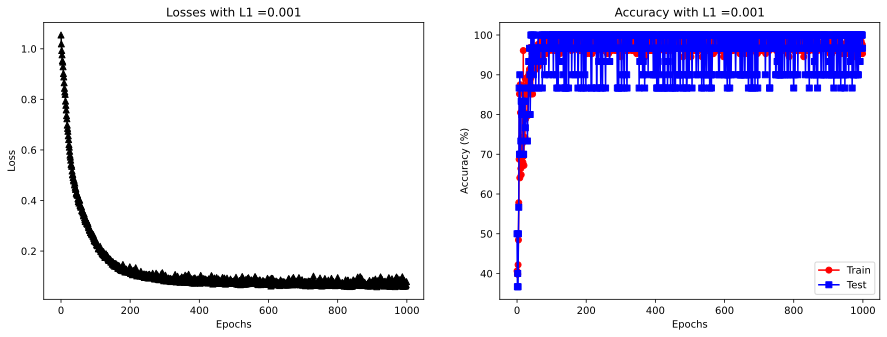

In [21]:
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 =' + str(L1lambda))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 =' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [22]:
def smooth(x,k):
      return np.convolve(x,np.ones(k)/k,mode='same')
     

In [26]:
L1lambda = np.linspace(0,.005,10)


accuracyResultsTrain = np.zeros((numepoches,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepoches,len(L1lambda)))



for li in range(len(L1lambda)):

  
    ANNiris,lossfun,optimizer = createANNmodel()
    trainAcc,testAcc,losses = trainTheModel(L1lambda[li])


    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li]  = smooth(testAcc,10)
     

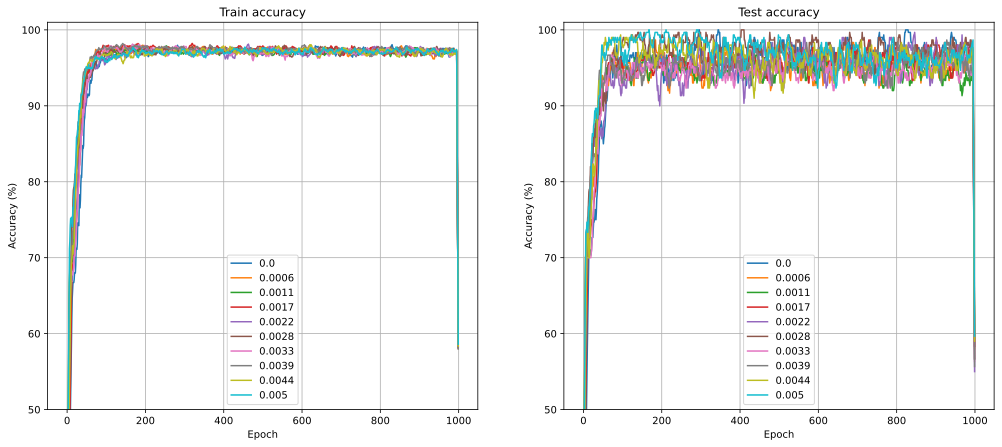

In [27]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')


leglabels = [np.round(i,4) for i in L1lambda]


for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

In [28]:
L1lambda = np.linspace(0,.005,5)


accuracyResultsTrain = np.zeros((numepoches,len(L1lambda)))
accuracyResultsTest  = np.zeros((numepoches,len(L1lambda)))



for li in range(len(L1lambda)):

  
    ANNiris,lossfun,optimizer = createANNmodel()
    trainAcc,testAcc,losses = trainTheModel(L1lambda[li])


    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li]  = smooth(testAcc,10)
     

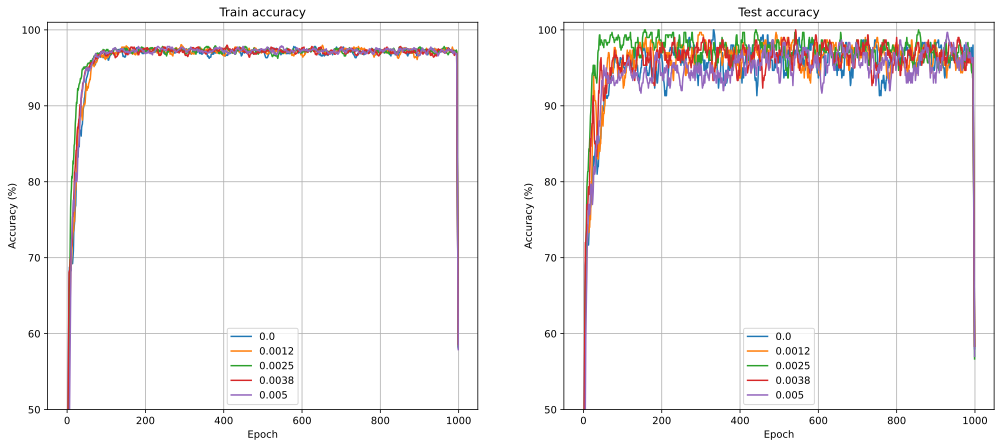

In [29]:
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')


leglabels = [np.round(i,4) for i in L1lambda]


for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

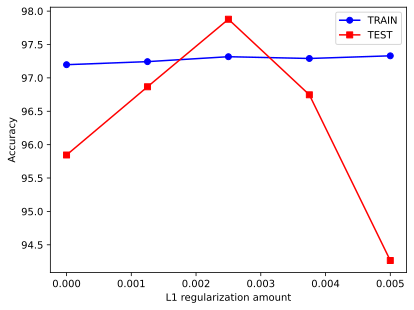

In [30]:
epoch_range = [160,360]


plt.plot(L1lambda,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L1lambda,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L1 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()